# Decision Trees, Random Forests, Boosting (100 P)

The goal of this homework is to extend decision trees, using (1) random forests or (2) boosting. For this, we will make use of an existing decision tree implementation (available in `scikit-learn`), that we can then reuse for implementing the two models of interest. As a first step, we download a simple two-dimensional classification dataset: the Iris data. The following code loads the data and retains only the first two input dimensions so that the problem can be easily visualized.

In [2]:
import sklearn,sklearn.datasets
iris = sklearn.datasets.load_iris()
X,T = iris.data[:,:2],iris.target

The function `plot_iris` from the modules `utils.py` takes as input a classification function mapping a data matrix containing the two input features for each data point a vector representing the classification of each data point. Then, the `plot_iris` function plots the decision function in superposition to the Iris dataset. In the example below, the prediction function assigns to each data point the output 0 (corresponding to the first class, shown in red).

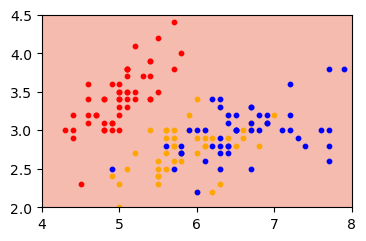

In [4]:
%matplotlib inline
import numpy,utils
utils.plot_iris(X,T,lambda X: numpy.dot(X,[0,0]))

## Decision Trees

We now consider the decision tree classifier readily available in `scikit-learn`. We use the default parameters of the classifier and only specify its the maximum tree depth.

In [6]:
import sklearn.tree
classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5)

In order to test the prediction accuracy of the classifier, one needs to split the dataset into a training and test set. The function `utils.split` achieves this by assigning a random 50% of the data for training and the remaining 50% for testing.

In [8]:
(Xtrain,Ttrain),(Xtest,Ttest) = utils.split(X,T)

Once the splitting is done, the training data can be used to fit the classifier. The learned prediction function and the test data are then sent to the Iris plotting function to visualize the classifier.

Classification Predictions on TRAINING Data


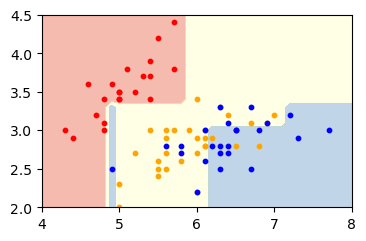

Classification Predictions on TEST Data


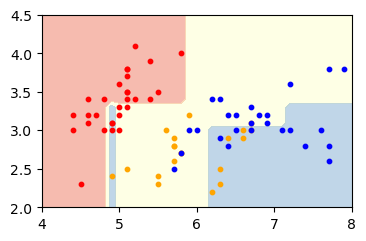

In [10]:
classifier.fit(Xtrain,Ttrain)
print('Classification Predictions on TRAINING Data')
utils.plot_iris(Xtrain, Ttrain, classifier.predict)
print('Classification Predictions on TEST Data')
utils.plot_iris(Xtest,Ttest,classifier.predict)

Here, the classifier does a reasonable job at classifying the data, although the decision boundaries are a bit too rectangular, and somewhat unnatural.

## Random Forest Classifier (30 P)

We would like to now compare the decision boundary of the decision tree with the one obtained with a random forest classifier. We consider a random forest composed of 100 trees. Each tree is trained on 50% subset of the training set. (Hint: The function `utils.split` can be called with seeds from 0 to 100 in order to build these random subsets.) The prediction function should implement a majority voting between each tree in the forest. Voting ties do not need to be handled in a particular way.

 * **Implement the `fit` and `predict` functions of the random forest classifier below**

In [14]:
from collections import Counter

# -------------------------------
# Auxiliary function
# -------------------------------
def majority_vote(Y):
    y = numpy.zeros(len(Y))
    for n in range(len(Y)):                      # iterate over each sample in data set
        counter_n = Counter(Y[n,:])              # convert predictions of trees in counterable form
        y[n] = counter_n.most_common(1)[0][0]    # retrieve most common prediction
    return y
# -------------------------------    

class RandomForestClassifier:
    
    def __init__(self):
        self.trees = [sklearn.tree.DecisionTreeClassifier(max_depth=5)
                      for _ in range(100)]
    
    def fit(self,X,y):
        # -------------------------------
        # TODO: replace by your solution
        # -------------------------------
        for i, tree in enumerate(self.trees):
            (Xtrain,Ttrain) = utils.split(X,y,seed=i)[0]  # each tree is split on a random subset (seed is set to get reproducable results)
            tree.fit(Xtrain,Ttrain)                       # fit each tree on its random subset
        # -------------------------------
        
    def predict(self,X):
        # -------------------------------
        # TODO: replace by your solution
        # -------------------------------
        Y = numpy.zeros((len(X), len(self.trees)))
        for i, tree in enumerate(self.trees):
            Y[:,i] = tree.predict(X)           # store the predictions made by each tree
        return majority_vote(Y)                # return most common prediction

        # -------------------------------
        # alternative solution
        # -------------------------------
        """Y = 0.0                                     # Y will be of size (1066,3) which is the number of samples x number of classes
        for tree in self.trees:
            Y = Y + numpy.eye(3)[tree.predict(X)]   # for each data sample an array of length 3 (3 = number of classes) is created 
                                                    # which counts how often the the specific class was predicted
                                                    # by adding a 1 to the corresponding entry
                                                    # Example: for the n-th sample 'tree' predicts class 2
                                                    # tree.predict(X) --> 2
                                                    # numpy.eye(3)[tree.predict(X)] --> [0,0,1]
                                                    # the counts are updated only for class 2 --> Y + [0,0,1] 
        return numpy.argmax(Y,axis=1)"""
        # -------------------------------

The code below runs the random forest classifier on the same dataset as before.

Classification Predictions on TRAINING Data


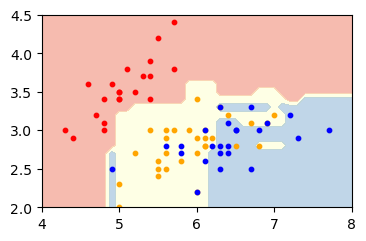

Classification Predictions on TEST Data


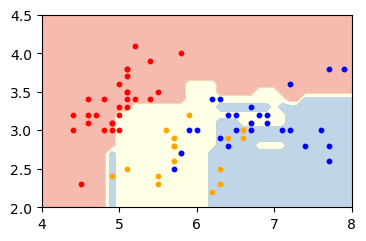

In [16]:
cl = RandomForestClassifier()

(Xtrain,Ttrain),(Xtest,Ttest) = utils.split(X,T)
cl.fit(Xtrain,Ttrain)
print('Classification Predictions on TRAINING Data')
utils.plot_iris(Xtrain, Ttrain, cl.predict)
print('Classification Predictions on TEST Data')
utils.plot_iris(Xtest,Ttest,cl.predict)

Unlike the decision boundary obtained by a single decision tree, the random forest tends to produce more curved and natural-looking decision functions.

## Quantitative Experiments

We now focus on understanding more quantitatively the effect on the model accuracy of choosing different models and their parameters. For this, we switch to the regression case, and consider two different datasets also available in `scikit-learn`, the bodyfat dataset, and the diabetes dataset.

In [19]:
bodyfat  = sklearn.datasets.fetch_openml(name="bodyfat", version=1)
diabetes = sklearn.datasets.load_diabetes()

C:\Users\hanna\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


The file `utils.py` provides a method `benchmark`, that tests the performance of a model on 100 different train/test splits, and returns the average training and test performance scores. For regression task, the performance score is given by the R2 coefficient of determination (see here https://en.wikipedia.org/wiki/Coefficient_of_determination). A score of "1" is optimal. A score of "0" is essentially random guessing.

In [21]:
regressor = sklearn.tree.DecisionTreeRegressor(max_depth=5)
strain,stest = utils.benchmark(regressor,bodyfat)
print('training: %.3f | test score: %.3f'%(strain,stest))

training: 0.997 | test score: 0.949


In the example above, the test data is predicted fairly well with a coefficient determination above 0.7. Furthermore, we can investigate the effect of depth on the decision tree:

In [23]:
for d in range(1,10):
    regressor = sklearn.tree.DecisionTreeRegressor(max_depth=d)
    strain,stest = utils.benchmark(regressor,bodyfat)
    print('depth: %d | training score: %.3f | test score: %.3f'%
                                                 (d,strain,stest))

depth: 1 | training score: 0.676 | test score: 0.664
depth: 2 | training score: 0.890 | test score: 0.874
depth: 3 | training score: 0.962 | test score: 0.927
depth: 4 | training score: 0.988 | test score: 0.943
depth: 5 | training score: 0.997 | test score: 0.949
depth: 6 | training score: 0.999 | test score: 0.950
depth: 7 | training score: 1.000 | test score: 0.949
depth: 8 | training score: 1.000 | test score: 0.948
depth: 9 | training score: 1.000 | test score: 0.949


Although the training error keeps increasing, the test error saturates once a depth of 6 has been reached. The same experiment can be performed on the diabetes dataset:

In [25]:
for d in range(1,10):
    regressor = sklearn.tree.DecisionTreeRegressor(max_depth=d)
    strain,stest = utils.benchmark(regressor,diabetes)
    print('depth: %d | training score: %.3f | test score: %.3f'%
                                                  (d,strain,stest))

depth: 1 | training score: 0.319 | test score: 0.220
depth: 2 | training score: 0.462 | test score: 0.334
depth: 3 | training score: 0.557 | test score: 0.315
depth: 4 | training score: 0.649 | test score: 0.254
depth: 5 | training score: 0.739 | test score: 0.180
depth: 6 | training score: 0.820 | test score: 0.108
depth: 7 | training score: 0.884 | test score: 0.035
depth: 8 | training score: 0.930 | test score: -0.007
depth: 9 | training score: 0.960 | test score: -0.044


Here, the best depth is just 2, and the model quality seriously degrades as we continue growing the tree. This is the result of overfitting, i.e. as we make the model closer to the data (bias reduction), we are also become highly sensitive to noise in the data and in the sampling process (variance increase).

## Implementing a Random Forest Regressor (30 P)

One way of reducing variance is to average a large number of models. This is the idea of random forests. Here, we consider a random forest regressor. Like for the random forest classifier, each tree is grown on a random subset of the training set containing only half of the examples. As in the first exercise, the function `utils.split` can be used to generate these subsets. Because we are now implementing a regression model, we replace the majority voting by a simple averaging of the prediction of the different trees. The implementation below inherits some useful methods from the class `sklearn.base.RegressorMixin` in particular the function `score` measuring the coefficient of determination, which therefore does not need to be reimplemented.

 * **Implement the `fit` and `predict` functions of the random forest regressor below.**

In [28]:
class RandomForestRegressor(sklearn.base.RegressorMixin):
    
    def __init__(self,max_depth=None,nb_trees=10):
        self.trees = [sklearn.tree.DecisionTreeRegressor(max_depth=max_depth)
                      for _ in range(nb_trees)]
    
    def fit(self,X,y):
        # -------------------------------
        # TODO: replace by your solution
        # -------------------------------
        for i, tree in enumerate(self.trees):                  # fit function is the same as in previous exercise 
            (Xtrain,Ttrain) = utils.split(X,y,seed=i)[0]
            tree.fit(Xtrain,Ttrain)
        # -------------------------------
        
    def predict(self,X):
        # -------------------------------
        # TODO: replace by your solution
        # -------------------------------
        Y = numpy.zeros((len(X), len(self.trees)))  # predict function is the same as in previous exercise, except for the final decision
        for i, tree in enumerate(self.trees):
            Y[:,i] = tree.predict(X)
        return Y.mean(axis=1)                       # replace majority voting by average of the trees' predictions
        # -------------------------------

To check whether the random forest brings an improvement over the simple decision tree algorithm, we select the best decision tree obtained so far (`d=7`), and compare its accuracy to our random forest regressor. Here, because of the averaging effect of the random forest, we can afford higher depths, for example, `d=9`. The code below test the performance of random forests of increasingly many trees.

In [30]:
# Benchmark for baseline decision tree model
regressor = sklearn.tree.DecisionTreeRegressor(max_depth=7)
strain,stest = utils.benchmark(regressor,bodyfat)
print("decision tree (optimal depth): | train: %.3f | test: %.3f"%
      (strain,stest))

# Benchmark for the random forest model with a growing number of trees
for nb_trees in [1,2,4,8,16,32]:
    regressor = RandomForestRegressor(max_depth=9,nb_trees=nb_trees)
    strain,stest = utils.benchmark(regressor,bodyfat)
    print("random forest with %2d tree(s): | train: %.3f | test: %.3f"%
          (nb_trees,strain,stest))

decision tree (optimal depth): | train: 1.000 | test: 0.950
random forest with  1 tree(s): | train: 0.961 | test: 0.928
random forest with  2 tree(s): | train: 0.978 | test: 0.949
random forest with  4 tree(s): | train: 0.985 | test: 0.957
random forest with  8 tree(s): | train: 0.988 | test: 0.963
random forest with 16 tree(s): | train: 0.990 | test: 0.964
random forest with 32 tree(s): | train: 0.990 | test: 0.965


As it can be observed from the results above, the test scores of a random forest are much better. Due to their high performance, random forests are often used in practical applications.

## Implementing a Simple Boosted Tree Regressor (40 P)

Another extension to the simple decision tree regressor, is the boosted tree regressor. Here, instead of averaging a large number of trees grown from randomly sampled data, the extra trees serve to predict what the previous trees failed to predict, i.e. the residual error. Technically, the variant of the boosted tree regressor we consider here is defined as follows:

Let $F_k(x) = f_1(x) + f_2(x) + \dots + f_k(x)$ be the prediction of a boosted regressor with $k$ trees, and some ground truth function $y(x)$, the next boosted regressor adds an additional decision tree $f_{k+1}(x)$ trained on the residual function $r(x) = y(x) - F_k(x)$, and the resulting boosted classifier becomes $F_{k+1}(x) = f_1(x) + f_2(x) + \dots + f_k(x) + f_{k+1}(x)$.

* **Implement the methods `fit` and `predict` of the simple boosted regression tree below.**

In [36]:
class SimpleBoostedTreeRegressor(sklearn.base.RegressorMixin):
    
    def __init__(self,max_depth=None,nb_trees=10):
        self.trees = [sklearn.tree.DecisionTreeRegressor(max_depth=max_depth)
                      for _ in range(nb_trees)]
    
    def fit(self,X,y):
        # -------------------------------
        # TODO: replace by your solution
        # -------------------------------
        F = numpy.zeros(len(X))  # current prediciton
        r = y                    # residual error
        for tree in self.trees:
            tree.fit(X,r)        # i-th tree is trained on the same data but with the residual error as target label
            F += tree.predict(X) # add the prediction, made by the i-th tree, to current overall prediciton
            r = y - F            # update residual error
        # -------------------------------
        
    def predict(self,X):
        # -------------------------------
        # TODO: replace by your solution
        # -------------------------------
        Y = numpy.zeros(len(X))
        for tree in self.trees:
            Y += tree.predict(X) # overall prediction is simply the sum of all trained trees
        return Y
        # -------------------------------

The code below compares the boosted tree regressor to the simple decision tree on the diabetes dataset. Here, we use for the decision tree a depth 2, that yields maximum accuracy on this dataset. As boosting allows to grows complex decisions from weak regressors, we set maximum tree depth to 1.

In [38]:
# Benchmark for baseline decision tree model
regressor = sklearn.tree.DecisionTreeRegressor(max_depth=2)
strain,stest = utils.benchmark(regressor,diabetes)
print("decision tree (optimal depth): | train: %.3f | test: %.3f"%
      (strain,stest))

# Benchmark for the boosted tree regressor model with a growing number of trees
for nb_trees in [1,2,4,8,16,32,64]:
    regressor = SimpleBoostedTreeRegressor(max_depth=1,nb_trees=nb_trees)
    strain,stest = utils.benchmark(regressor,diabetes)
    print("boosting with %2d trees(s):     | train: %.3f | test: %.3f"%
          (nb_trees,strain,stest))

decision tree (optimal depth): | train: 0.462 | test: 0.334
boosting with  1 trees(s):     | train: 0.319 | test: 0.220
boosting with  2 trees(s):     | train: 0.427 | test: 0.317
boosting with  4 trees(s):     | train: 0.487 | test: 0.342
boosting with  8 trees(s):     | train: 0.558 | test: 0.357
boosting with 16 trees(s):     | train: 0.628 | test: 0.361
boosting with 32 trees(s):     | train: 0.699 | test: 0.349
boosting with 64 trees(s):     | train: 0.766 | test: 0.324


Like for the random forests, the boosted tree regressor also brings an improvement compared to the simple decision tree. Note that adding too many trees may still cause overfitting (here, a good number of trees is 16). If we would like to include more trees, an even weaker base model should be used if available.

### Dependency of regression performance on model complexity

Finally, we can study how the performance of each model depends on the tree depth. In this last experiment, the number of trees in the random forest and boosted model are kept fixed, and the tree depth is varied. Experiments are performed for all datasets and algorithms and results are shown as plots.

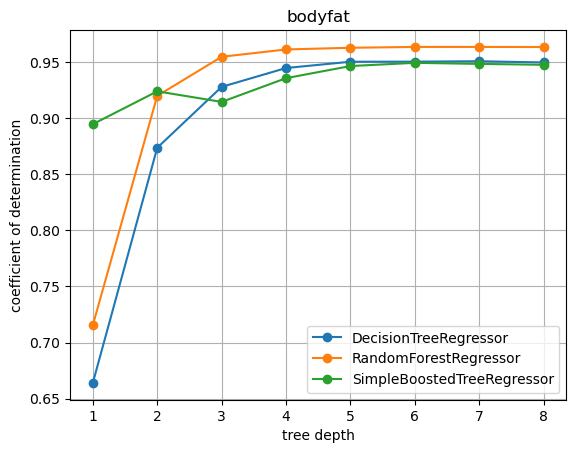

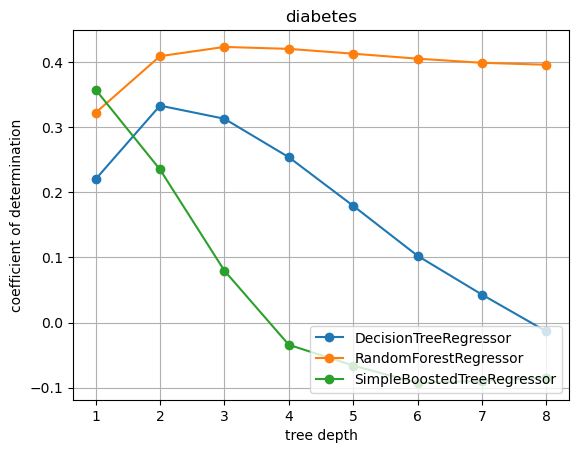

In [40]:
depths     = [1,2,3,4,5,6,7,8]
datasets   = [bodyfat,diabetes]
names      = ['bodyfat','diabetes']
algorithms = [sklearn.tree.DecisionTreeRegressor,
              RandomForestRegressor,
              SimpleBoostedTreeRegressor]

from matplotlib import pyplot as plt

for dataset,name in zip(datasets,names):
    plt.figure()
    plt.title(name)
    
    for algorithm in algorithms:
        
        acc = [utils.benchmark(algorithm(max_depth=i),dataset)[1]
               for i in depths]
        
        plt.plot(depths,acc,'o-',label=algorithm.__name__)

    plt.grid(True)
    plt.xlabel('tree depth')
    plt.ylabel('coefficient of determination')
    plt.legend(loc='lower right')
    plt.show()

It can be observed that the random forest method tends to prefer deep trees. Indeed, the variance increase caused by deeper trees is countered by the averaging mechanism. Conversely, the boosting algorithm prefers small trees as it is able to build complex models even from simple weak regressors.